In [ ]:
!git clone https://github.com/anonICLR2020/node.git
%cd node

Cloning into 'node'...
remote: Enumerating objects: 19, done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 19
Receiving objects: 100% (19/19), 237.17 KiB | 5.65 MiB/s, done.
/content/node


In [ ]:
!pip install -r /content/drive/MyDrive/Colab\ Notebooks/node-master/requirements.txt
!pip install lib
!pip install category_encoders
!pip install qhoptim
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0,1
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import lib
import matplotlib.pyplot as plt
%matplotlib inline
from qhoptim.pyt import QHAdam
from category_encoders import LeaveOneOutEncoder
import torch, torch.nn as nn
import torch.nn.functional as F
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'


     \ 6.5 MB 15.4 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl 

In [ ]:
experiment_name = 'Saber_pro prediction'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

experiment: Saber_pro prediction_2024.06.18_14:13


In [ ]:
# Load the datasets
X_train_df = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/train_OLeave.csv')
X_valid_df = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/valid_OLeave.csv')
X_test_df = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/test_OLeave.csv')

# Drop 'Global_Score_pro' and 'ID' columns from X_train
X_train_filtered = X_train_df.drop(columns=['Global_Score_pro', 'ID'])

# Calculate in_features
in_features = X_train_filtered.shape[1]

# Extract the target variables
y_train = X_train_df['Global_Score_pro'].values
y_valid = X_valid_df['Global_Score_pro'].values
y_test = X_test_df['Global_Score_pro'].values


X_train_df = X_train_df.drop(columns=['ID', 'Global_Score_pro' ])
X_valid_df = X_valid_df.drop(columns=['ID', 'Global_Score_pro'])
X_test_df = X_test_df.drop(columns=['ID', 'Global_Score_pro'])


# Convert data to NumPy arrays
X_train = X_train_df.values
X_valid = X_valid_df.values
X_test = X_test_df.values

In [ ]:
mu, std = y_train.mean(), y_train.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
y_train, y_valid, y_test = map(normalize, [y_train, y_valid, y_test])
print("mean = %.5f, std = %.5f" % (mu, std))

mean = 154.25792, std = 25.46442


In [ ]:
# Convert data to PyTorch tensors and ensure they are of float type
X_train = torch.from_numpy(X_train).float()
X_valid = torch.from_numpy(X_valid).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_valid = torch.from_numpy(y_valid).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
#establish model
model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=8, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree

).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(X_train[:1000], device=device))
    # trigger data-aware init

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [ ]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }


In [ ]:
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)


In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 1000
report_frequency = 100

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

<Figure size 640x480 with 0 Axes>

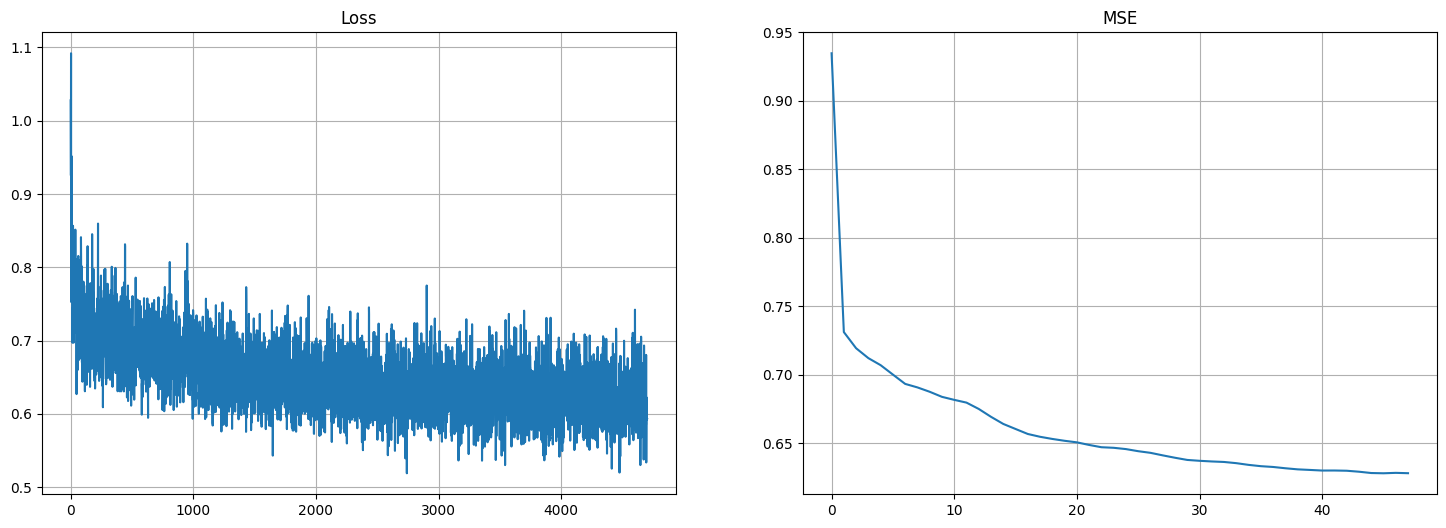

Loss 0.59328
Val MSE: 0.62817
BREAK. There is no improvement for 200 steps
Best step:  4501
Best Val MSE: 0.62811


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import gc
import torch
from IPython.display import clear_output

# Placeholder variables
loss_history = []
mse_history = []
best_mse = float('inf')
best_step_mse = 0
report_frequency = 100  # Frequency of reporting and validation
early_stopping_rounds = 200  # Steps to wait for improvement before stopping

# Assuming lib.iterate_minibatches, lib.Trainer, and other components are correctly defined and imported
# Use the actual batch size and number of epochs
for step, batch in enumerate(lib.iterate_minibatches(X_train, y_train, batch_size=1024, shuffle=True, epochs=2000)):
    metrics = trainer.train_on_batch(*batch, device=device)

    # Detach loss before appending to the history
    loss_history.append(metrics['loss'].detach().cpu().numpy())

    if step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(X_valid, y_valid, device=device, batch_size=2048)

        gc.collect()
        torch.cuda.empty_cache()

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
            # Save the model state
            torch.save(trainer.model.state_dict(), 'best_model.pth')
        mse_history.append(mse)

        trainer.load_checkpoint()  # Load the most recent checkpoint
        trainer.remove_old_temp_checkpoints()

        # Plotting
        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(mse_history)
        plt.title('MSE')
        plt.grid()
        plt.show()
        plt.savefig("NODE_performance.png", dpi=100)
        print("Loss %.5f" % (metrics['loss'].detach().cpu().numpy()))
        print("Val MSE: %0.5f" % (mse))

    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvement for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

In [ ]:
trainer.load_checkpoint(tag='best_mse')
mse = trainer.evaluate_mse(X_test, y_test, device=device)
print('Best step: ', trainer.step)
print("Test MSE: %0.5f" % (mse))

Loaded logs/Saber_pro prediction_2024.06.18_14:13/checkpoint_best_mse.pth
Best step:  4501
Test MSE: 0.62625


In [ ]:
#MSE on test
mse * std ** 2

406.08628579132125

In [ ]:
# Load the best checkpoint
trainer.load_checkpoint(tag='best_mse')

# Evaluate on the test set in smaller batches
batch_size = 1024  # Adjust as needed based on your GPU memory
predictions = []
with torch.no_grad():
    for i in range(0, X_test.shape[0], batch_size):
        batch_predictions = trainer.model(X_test[i:i+batch_size].to(device)).cpu().numpy()
        predictions.append(batch_predictions)

# Concatenate predictions from all batches
predictions = np.concatenate(predictions, axis=0)

# Inject noise into predictions
noise = np.random.normal(loc=0, scale=0.1, size=predictions.shape)
noisy_predictions = predictions + noise

# Compute MSE with noisy predictions
mse = np.mean((noisy_predictions - y_test.cpu().numpy())**2)

# Print results
print('Best step: ', trainer.step)
print("Test MSE with noise: %0.5f" % (mse))


Loaded logs/Saber_pro prediction_2024.06.18_14:13/checkpoint_best_mse.pth
Best step:  4501
Test MSE with noise: 0.63587


In [ ]:
mse * std ** 2

412.32127459835476

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 9.4 MB/s eta 0:00:00


In [ ]:
import shap

  0%|          | 0/100 [00:00<?, ?it/s]

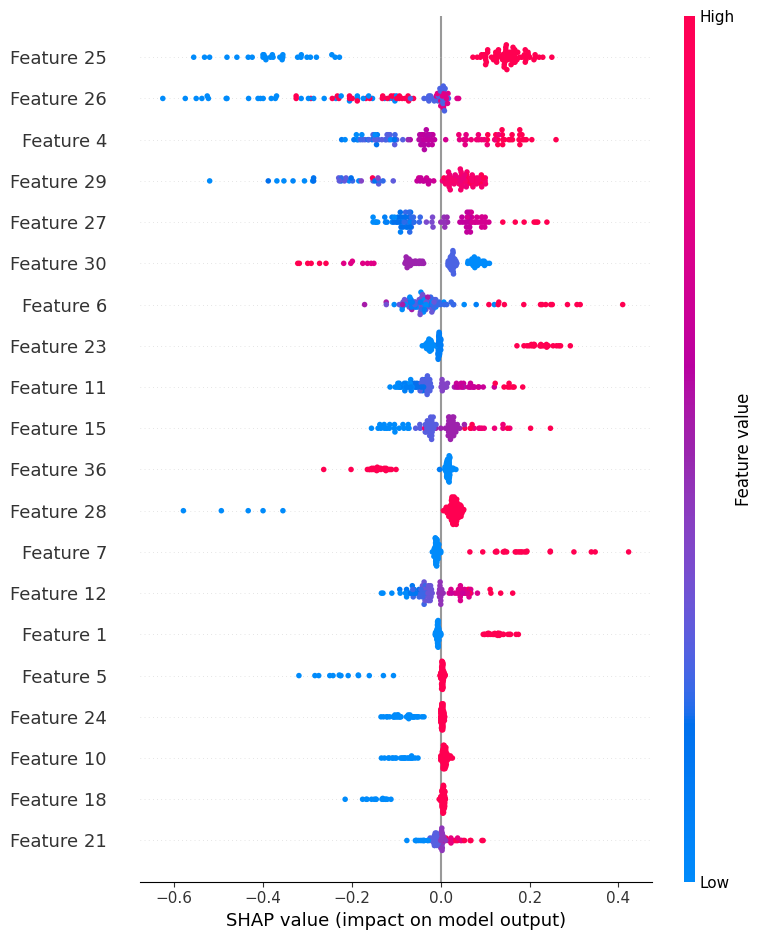

In [ ]:
import shap
import torch
import numpy as np

# Load the model state
loaded_clf = trainer.model
loaded_clf.load_state_dict(torch.load('best_model.pth'))
loaded_clf.eval()

# Ensure X_train is a NumPy array (convert back from PyTorch tensor if necessary)
X_test_np = X_test.cpu().numpy()  # Convert to numpy if X_train is a torch tensor

# Define a predict function for the loaded model that runs on CPU to save GPU memory
def model_predict(X):
    with torch.no_grad():
        # Move the input tensor to CPU explicitly
        X_tensor = torch.tensor(X, dtype=torch.float32).cpu()
        # Ensure the model is also moved to CPU
        loaded_clf.to('cpu')
        predictions = loaded_clf(X_tensor).cpu().numpy()
    return predictions

# Reduce the size of the background summary to reduce memory usage
background_summary = shap.kmeans(X_test_np, 50)  # Adjust the number of clusters based on your RAM capacity

# Create the SHAP KernelExplainer using the model_predict function and background summary
explainer = shap.KernelExplainer(model_predict, background_summary)

# Limit the number of samples for explanation to reduce memory usage
num_samples = 100
random_indices = np.random.choice(X_test_np.shape[0], num_samples, replace=False)
X_sample = X_test_np[random_indices]
# Compute the SHAP values
shap_values = explainer.shap_values(X_sample)
3
# Plot the SHAP values for the first sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_sample[0])

# Optional: Plot summary plot for the sample
shap.summary_plot(shap_values, X_sample)



In [ ]:
# Assuming your feature names are stored in a variable called feature_names
feature_names = X_train_filtered.columns.tolist()  # Assuming df is your DataFrame


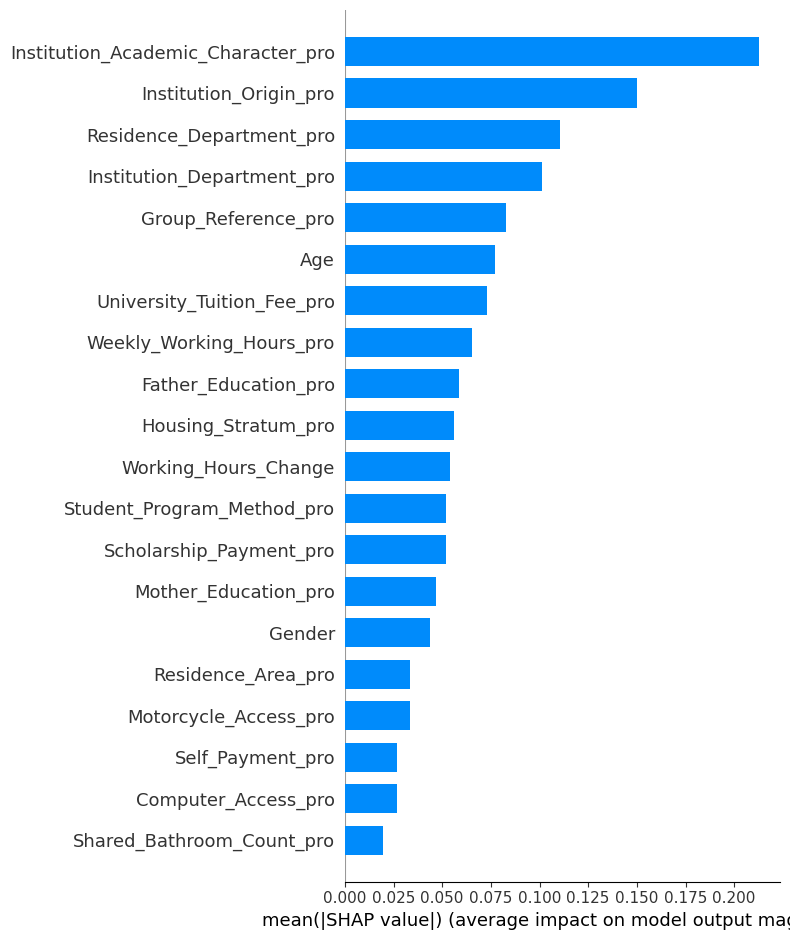

In [ ]:
# Plot the summary plot with vertical feature names and adjust figure size
plt.figure(figsize=(10, 10 ))  # Adjust the figsize as needed
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type='bar')


In [ ]:
pip install dalex -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042471 sha256=0fd9d5a9004416fc8f578260b4a9489ad3324d632238bc3319a42372ce1e2979
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


In [ ]:
import dalex as dx
print(dx.__version__)

1.7.0


In [ ]:
# Load the datasets
X_train_df = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/train_OLeave.csv')
X_valid_df = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/valid_OLeave.csv')
X_test_df = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/test_OLeave.csv')

# Drop 'Global_Score_pro' and 'ID' columns from X_train
X_train_filtered = X_train_df.drop(columns=['Global_Score_pro', 'ID'])

# Calculate in_features
in_features = X_train_filtered.shape[1]

# Extract the target variables
y_train = X_train_df['Global_Score_pro'].values
y_valid = X_valid_df['Global_Score_pro'].values
y_test = X_test_df['Global_Score_pro'].values


X_train_df = X_train_df.drop(columns=['ID', 'Global_Score_pro' ])
X_valid_df = X_valid_df.drop(columns=['ID', 'Global_Score_pro'])
X_test_df = X_test_df.drop(columns=['ID', 'Global_Score_pro'])


# Convert data to NumPy arrays
X_train = X_train_df.values
X_valid = X_valid_df.values
X_test = X_test_df.values

In [ ]:

# Load the saved model
model_filename = "best_model.pth"
model = torch.load(model_filename)
model.eval()  # Set the model to evaluation mode

# Assuming test_set is already defined
# Define features for test set
X_test = test_set.drop(columns=['ID', 'Global_Score_pro'])

# Obtain true target values for the test set
y_test = test_set['Global_Score_pro']

# Create the dalex explainer for the model
exp = dx.Explainer(model, X_test, y_test, verbose=False)

# Print the explainer to check it's working
print(exp)

# Calculate model performance
mp = exp.model_performance()
print(mp.result)

# Assess fairness
# For example, to check fairness across a sensitive attribute 'sensitive_attribute_name'
sensitive_attribute_name = 'sensitive_attribute'  # replace with the actual column name
fairness = exp.model_fairness(protected = sensitive_attribute_name)
print(fairness.result)


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'